In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import scipy as sp
import datetime as dt

from ei_net import *
from ce_net import *

from collections import Counter

%matplotlib inline

In [2]:
# import numpy as np
# import networkx as nx
# from scipy.sparse import csr_matrix
# from scipy.stats import entropy

# def check_network(G):
#     if isinstance(G, csr_matrix):
#         G = nx.to_scipy_sparse_array(G, create_using=nx.DiGraph())
#     elif isinstance(G, np.ndarray):
#         G = nx.from_numpy_matrix(G)
#     elif isinstance(G, nx.Graph) and not isinstance(G, nx.DiGraph):
#         G = nx.DiGraph(G)
    
#     if nx.get_edge_attributes(G, 'weight'):
#         weights = {}
#         for i in G.nodes():
#             out_edges = list(G.out_edges(i, data=True))
#             k = len(out_edges)
#             weights_i_sum = sum(e[2]['weight'] for e in out_edges)
#             for eij in out_edges:
#                 weights[(eij[0], eij[1])] = eij[2]['weight'] / weights_i_sum
#         nx.set_edge_attributes(G, weights, 'weight')
#     else:
#         weights = {eij: 1. / len(G.out_edges(i)) for i in G.nodes() for eij in G.out_edges(i)}
#         nx.set_edge_attributes(G, weights, 'weight')

#     old_node_labels = list(G.nodes())
#     new_node_labels = list(range(G.number_of_nodes()))
#     node_label_mapping = dict(zip(old_node_labels, new_node_labels))
#     node_label_mapping_r = dict(zip(new_node_labels, old_node_labels))

#     G = nx.relabel_nodes(G, node_label_mapping, copy=True)
#     nx.set_node_attributes(G, node_label_mapping_r, 'label')

#     return G

# def stationary_distribution(G, smallest=1e-10):
#     """
#     Return a stationary probability vector of a given network

#     x = xA where x is the answer
#     x - xA = 0
#     x( I - A ) = 0 and sum(x) = 1

#     Parameters
#     ----------
#     G (nx.Graph or np.ndarray): the network in question.
#     smallest (float): magnitude of probability that should be set to zero.

#     Returns
#     -------
#     P (np.ndarray): vector of stationary probabilities of random walkers.

#     """

#     A = W_out(G)
#     N = A.shape[0]
#     a = np.eye(N) - A
#     a = np.vstack((a.T, np.ones(N)))
#     b = np.matrix([0] * N + [1]).T

#     P = np.linalg.lstsq(a, b, smallest)[0]
#     P[P < smallest] = 0

#     if sum(P) != 1.0 and sum(P) != 0:
#         P = P / sum(P)

#     return np.array(P).reshape(N)

# def W_out(G):
#     G = check_network(G)
#     return nx.to_numpy_array(G)

# def W_in(G, intervention_distribution='Hmax'):
#     Wout = W_out(G)
#     if intervention_distribution == 'Hmax':
#         IntD = np.ones(Wout.shape[0]) / Wout.shape[0]
#     else:
#         IntD = np.array(intervention_distribution) / sum(intervention_distribution)

#     Win = Wout.T.dot(IntD)
#     return Win / sum(Win) if sum(Win) else np.zeros(len(Win))

# def effective_information(G):
#     G = check_network(G)
#     N = G.number_of_nodes()
#     Nout = len([d for d in dict(G.out_degree()).values() if d > 0])

#     if Nout > 0:
#         Wout = np.zeros(N)
#         Win = np.zeros(N)

#         for i, node_i in enumerate(G.nodes()):
#             Wout_i = [data['weight'] for _, _, data in G.out_edges(node_i, data=True)]
#             Wout[i] = entropy(Wout_i, base=2)
#             for j, data in G[node_i].items():
#                 Win[j] += data['weight'] / Nout

#         Wout_average = np.sum(Wout) / Nout
#         Win_entropy = entropy(Win, base=2)

#         return Win_entropy - Wout_average
#     else:
#         return 0.0
    
# def effectiveness(G):
#     G = check_network(G)
#     return effective_information(G) / np.log2(G.number_of_nodes())

# def determinism(G, intervention_distribution='Hmax'):
#     """
#     The determinism is the uncertainty in outcomes following an intervention
#     into its states. Under a uniform intervention into a system's states,
#     this equation becomes:

#     $ det = log2(N) - frac{1}{Nout} sum_i^Nout H[W_i^{out}] $

#     Parameters
#     ----------
#     G (nx.Graph or np.ndarray): the network in question.
#     intervention_distribution (np.ndarray or str): if 'Hmax', this represents a
#             uniform intervention into a system's states. Otherwise, it's a
#             heterogeneous intervention, often used in causal emergence (because
#             a coarse-graining can be interpreted as changing the kinds of
#             interventions that are informative about a given system).


#     Returns
#     -------
#     det (float): the determinism of the network.

#     """

#     Wout = W_out(G)

#     # Wout_noise is only calculated in nodes that have outputs
#     eligible_nodes = np.nonzero(Wout.sum(axis=1))[0]

#     Nout = len(eligible_nodes)

#     if str(intervention_distribution) == 'Hmax':
#         IntD = np.ones(Wout.shape[0])/Wout.shape[0]
#     else:
#         if sum(intervention_distribution) >= 0.0:
#             IntD = intervention_distribution / sum(intervention_distribution)
#         else:
#             return np.zeros(Wout.shape[0])

#     if Nout > 0 and sum(sum(Wout)) > 0:
#         det = sum([entropy(Wout_i, IntD, base=2)
#                    for Wout_i in Wout[eligible_nodes]])

#         return det / Nout

#     else:
#         return 0.0


# def degeneracy(G, intervention_distribution='Hmax'):
#     """
#     The degeneracy is the heterogeneity of the effect distribution following an
#     intervention into a system's states. Under a uniform intervention into a
#     system's states, this becomes:

#     $ deg = log2(N) - H[W_i^{out}] $

#     Parameters
#     ----------
#     G (nx.Graph or np.ndarray): the network in question.
#     intervention_distribution (np.ndarray or str): if 'Hmax', this represents
#             a uniform intervention into a system's states. Otherwise, it's a
#             heterogeneous intervention, often used in causal emergence (because
#             a coarse-graining can be interpreted as changing the kinds of
#             interventions that are informative about a given system).

#     Returns
#     -------
#     deg (float): the degeneracy of the network.

#     """

#     Wout = W_out(G)

#     if str(intervention_distribution) == 'Hmax':
#         IntD = np.ones(Wout.shape[0])/Wout.shape[0]
#     else:
#         if sum(intervention_distribution) >= 0.0:
#             IntD = intervention_distribution / sum(intervention_distribution)
#         else:
#             return np.zeros(Wout.shape[0])

#     Win = W_in(G, IntD)
#     nodes_with_input = np.nonzero(Win)[0]

#     if len(nodes_with_input) > 0:
#         intervened = np.nonzero(IntD)[0]
#         deg = entropy(Win[intervened], IntD[intervened], base=2)
#         return deg
#     else:
#         return 0.0


# def create_macro(G, macro_mapping, macro_types={}):
#     r"""
#     Coarse-grains a network according to the specified macro_mapping and
#     the types of macros that each macro is associated with.

#     Parameters
#     ----------
#     G (nx.Graph or np.ndarray): the network in question.
#     macro_mapping (dict): a dictionary where the keys are the microscale nodes
#              and the values represent the macronode that they are assigned to.
#     macro_types (dict): the corresponding macro_types dictionar associated
#                     with the type of macronode in the "winning" G_macro.

#     Returns
#     -------
#     M (np.ndarray): coarse-grained network according to the mapping of micro
#                     nodes onto macro nodes, given by macro_mapping.

#     """

#     G_micro = check_network(G)
#     Wout_micro = W_out(G_micro)
#     # if macro_mapping == {}:
#     #     return Wout_micro

#     if macro_types == {}:
#         macro_types = {j:'spatem1' for i, j in macro_mapping.items() if i != j}

#     # the size of the whole microscale network
#     micro_stationary = stationary_distribution(G_micro)

#     # list of nodes that are in the macroscale network
#     nodes_in_macro_network = list(np.unique(list(macro_mapping.values())))

#     # this is the max index of the non-spatem2 macros, every index above this
#     # then will be considered as a spatem2.
#     non_spatem2_max_index = max(nodes_in_macro_network) + 1
#     n_macros_spatem2 = len([i for i, j in macro_types.items()
#                             if j == 'spatem2'])
#     new_max_index_tmp = non_spatem2_max_index+n_macros_spatem2
#     macro_id_spatem2 = list(range(non_spatem2_max_index, new_max_index_tmp))

#     # now: these are the indices of the nodes in the TOO_BIG_MACRO
#     nodes_in_macro_network = nodes_in_macro_network + macro_id_spatem2
#     # the size of the TOO_BIG_MACRO that we will be filling in
#     n_TOO_BIG_MACRO = max(nodes_in_macro_network) + 1

#     # dictionary where the keys are the indices of the TOO_BIG_MACRO
#     # and the values are the indices of where they will be in the final
#     # matrix returned at the end, M
#     nodes_in_macro_network_mapping = {j: i for i, j in
#                                       enumerate(nodes_in_macro_network)}

#     # and make the big empty matrix
#     TOO_BIG_MACRO = np.zeros((n_TOO_BIG_MACRO, n_TOO_BIG_MACRO))

#     all_final_node_types = {i: 'micro' for i in nodes_in_macro_network if
#                             i < G_micro.number_of_nodes()}

#     for macro_i in nodes_in_macro_network_mapping.keys():
#         if macro_i not in all_final_node_types.keys():
#             all_final_node_types[macro_i] = 'spatem1'

#     macro_mumu_pairings = {}
#     spt2_ind_tmp = 0

#     for k, v in macro_types.items():
#         all_final_node_types[k] = v
#         if v == 'spatem2':
#             mu_mu = macro_id_spatem2[spt2_ind_tmp]
#             all_final_node_types[mu_mu] = 'mu_mu'
#             macro_mumu_pairings[k] = mu_mu
#             spt2_ind_tmp += 1

#     # now the goal is to fill in the TOO_BIG_MACRO with the correct values
#     # and, importantly, at the correct indices. do this with a for loop

#     for final_node_i in nodes_in_macro_network:
#         # this will be the vector that will be added to the TOO_BIG_MACRO
#         W_i_out_final = np.zeros(n_TOO_BIG_MACRO)

#         # we want to check every node for its type:
#         final_node_i_type = all_final_node_types[final_node_i]

#         ##########
#         # MICROS #
#         ##########
#         if final_node_i_type == 'micro':
#             # get the indices of the MICRO nodes that this particular micro
#             # node leads to, and the weights associated with those links
#             out_indices = np.nonzero(Wout_micro[final_node_i])[0]
#             out_weights = Wout_micro[final_node_i][out_indices]

#             # have a way to convert between the micro nodes it leads to and
#             # the macro index that they will eventually be associated with
#             new_indices = [macro_mapping[i] for i in out_indices]

#             for wij_ind, wij in enumerate(out_weights):
#                 W_i_out_final[new_indices[wij_ind]] += wij

#             TOO_BIG_MACRO[final_node_i, :] = W_i_out_final

#         ###########
#         # SPATIAL #
#         ###########
#         if final_node_i_type == 'spatial':
#             micros_in_macro_i = [i for i, m in macro_mapping.items()
#                                  if m == final_node_i]
#             macro_row_sum = np.zeros(Wout_micro.shape[0])

#             # get the rows of the Wout_micro associated with the micros
#             # in the macro node that we are currently on
#             Wout_macro_subgraph = Wout_micro[micros_in_macro_i, :]

#             # indices of the FINAL macro network that are not in the current
#             # macro. note that "nodes_in_macro_network" is the length of the
#             # size_of_final_macro, and its elements correspond to the *values*
#             # in macro_mapping
#             nodes_outside_macro_i = [i for i in nodes_in_macro_network if
#                                      i not in micros_in_macro_i and
#                                      i != final_node_i]

#             # same list as above, but this one uses microscale indices as its
#             # elements so that you can get the right exit rates from Wout_micro
#             nodes_outside_macro_mic_index = [i for i, j in
#                                              macro_mapping.items() if j in
#                                              nodes_outside_macro_i]

#             input_probs_to_macro = Wout_micro.T[micros_in_macro_i].T

#             # get the input to the nodes in the macro
#             for i in range(len(macro_row_sum)):
#                 macro_row_sum += Wout_macro_subgraph.T.dot(
#                                  input_probs_to_macro[i].T)

#             if sum(macro_row_sum) == 0:
#                 # then there are no inputs from outside
#                 W_i_out_final[final_node_i] = 1
#                 TOO_BIG_MACRO[final_node_i, :] = W_i_out_final

#             # chances are, it's not some huge isolated clique, so we need to
#             # calculate the out-weights of the nodes that make up the macro

#             else:
#                 # find the indices of micro nodes with input from macro scale
#                 out_indices = np.nonzero(
#                                          sum(Wout_micro[micros_in_macro_i])
#                                          [nodes_outside_macro_mic_index])[0]

#                 # and how do those indices map onto the new indices?
#                 new_indices = [nodes_outside_macro_mic_index[i] for
#                                i in out_indices]

#                 # now, we can fill the row of TOO_BIG_MACRO (corresponding
#                 # to the current macro node) with correct edge weight values.
#                 for i, wij_ind in enumerate(new_indices):
#                     # old_i   = out_indices[i]
#                     wij_out = macro_mapping[wij_ind]
#                     W_i_out_final[wij_out] += macro_row_sum[wij_ind]

#                 # and lastly, make a self-loop if there is any.
#                 selfloop = sum(macro_row_sum[micros_in_macro_i])
#                 if selfloop < 0:
#                     selfloop = 0

#                 W_i_out_final[final_node_i] = selfloop
#                 TOO_BIG_MACRO[final_node_i, :] = W_i_out_final /\
#                     sum(W_i_out_final)

#         ###########
#         # SPATEM1 #
#         ###########
#         if final_node_i_type == 'spatem1':
#             # these are the indices of the micros inside this spatem1 macro
#             micros_in_macro_i = [i for i, m in macro_mapping.items()
#                                  if m == final_node_i]

#             # get the rows of the Wout_micro associated with those indices
#             Wout_macro_subgraph = Wout_micro[micros_in_macro_i, :]

#             # get the stationary dist values of the micro nodes in this macro
#             macro_i_stationary = micro_stationary[micros_in_macro_i]

#             # get the total stationary probability inside this macro
#             macro_i_stationary_sum = sum(macro_i_stationary)

#             # weight the Wout_macro_subgraph by the stationary distribution
#             Wout_macro_subgraph_weighted = Wout_macro_subgraph.copy()
#             for j, W_j_out in enumerate(Wout_macro_subgraph):
#                 Wout_macro_subgraph_weighted[j] = W_j_out*macro_i_stationary[j]

#             # get the (FINAL macro net.) indices of nodes not inside this macro
#             nodes_outside_macro_i = [i for i in nodes_in_macro_network if
#                                      i not in micros_in_macro_i and
#                                      i != final_node_i]

#             # same list as above but this one uses microscale indices as its
#             # elements so that you can get the right exit rates from Wout_micro
#             nodes_outside_macro_mic_index = [i for i, j in
#                                              macro_mapping.items()
#                                              if j in nodes_outside_macro_i]

#             # a len(nodes_outside_macro_mic_index)x1 vector of exitrates
#             Wout_macro_i_exitrates = sum(Wout_macro_subgraph_weighted[:,
#                                          nodes_outside_macro_mic_index])

#             # total exit rate probability from the macro in question
#             Wout_macro_i_exitrates_sum = sum(Wout_macro_i_exitrates)

#             # if there are no edges w/ weights outside the macro, add selfloop
#             if Wout_macro_i_exitrates_sum == 0:
#                 W_i_out_final[final_node_i] = 1
#                 TOO_BIG_MACRO[final_node_i, :] = W_i_out_final

#             # chances are, it's not some huge isolated clique, so we
#             # calculate the out-weights of the nodes that make up the macro

#             else:
#                 # normalize Wout_macro_i_exitrates given macro_i_stationary_sum
#                 Wout_macro_i_exitrates_norm = Wout_macro_i_exitrates.copy()
#                 for i, wij in enumerate(Wout_macro_i_exitrates):
#                     Wout_macro_i_exitrates_norm[i] = wij/macro_i_stationary_sum

#                 # micro indices of nodes with inputs from nodes in this macro
#                 out_indices = np.nonzero(
#                                 sum(Wout_micro[micros_in_macro_i])
#                                 [nodes_outside_macro_mic_index])[0]

#                 # and how do those indices map onto the new indices?
#                 new_indices = [nodes_outside_macro_mic_index[i] for
#                                i in out_indices]

#                 # now, we can fill the row of TOO_BIG_MACRO (corresponding
#                 # to the current macro node) with correct edge weight values.
#                 for i, wij_ind in enumerate(new_indices):
#                     old_i = out_indices[i]
#                     wij_ind = macro_mapping[wij_ind]
#                     W_i_out_final[wij_ind] += \
#                         Wout_macro_i_exitrates_norm[old_i]

#                 # and lastly, make a self-loop if there is any.
#                 selfloop = 1 - sum(W_i_out_final)
#                 if selfloop < 0:
#                     selfloop = 0

#                 W_i_out_final[final_node_i] = selfloop
#                 TOO_BIG_MACRO[final_node_i, :] = W_i_out_final

#         ###########
#         # SPATEM2 #
#         ###########
#         if final_node_i_type == 'spatem2':
#             # for the mu_mu node, we need to add another row. This extra
#             # W_i_out_final node will just have a single 1.0 edge weight
#             # to the mu_mu macro node. This bit is primarily for finding
#             # the edge weights from mu_mu.
#             mu_mu_index = macro_mumu_pairings[final_node_i]
#             W_mu_out_final = np.zeros(n_TOO_BIG_MACRO)

#             # but first we need to find out which nodes are in the macro
#             micros_in_macro_i = [i for i, m in macro_mapping.items()
#                                  if m == final_node_i]

#             # get the rows of the Wout_micro associated with the micros
#             # in the macro node that we are currently on
#             Wout_macro_subgraph = Wout_micro[micros_in_macro_i, :]

#             # get the stationary dist values of the micro nodes in this macro
#             macro_i_stationary = micro_stationary[micros_in_macro_i]

#             # get the total stationary probability inside this macro
#             macro_i_stationary_sum = sum(macro_i_stationary)

#             # weight the Wout_macro_subgraph by the stationary
#             Wout_macro_subgraph_weighted = Wout_macro_subgraph.copy()
#             for j, W_j_out in enumerate(Wout_macro_subgraph):
#                 Wout_macro_subgraph_weighted[j] = W_j_out*macro_i_stationary[j]

#             # indices of the FINAL macro network that do not include
#             nodes_outside_macro_i = [i for i in nodes_in_macro_network if
#                                      i not in micros_in_macro_i and
#                                      i != final_node_i]

#             # same list as above but this uses the microscale indices as its
#             # elements so that you can get the right exit rates from Wout_micro
#             nodes_outside_macro_mic_index = [i for i, j in
#                                              macro_mapping.items()
#                                              if j in nodes_outside_macro_i]

#             # a len(nodes_outside_macro_mic_index)x1 vector of exitrates
#             Wout_macro_i_exitrates = sum(
#                 Wout_macro_subgraph_weighted[:, nodes_outside_macro_mic_index])

#             # total exit rate probability from the macro in question
#             Wout_macro_i_exitrates_sum = sum(Wout_macro_i_exitrates)

#             # if there are no edges with weights outside the macro,
#             # then give it a self-loop
#             if Wout_macro_i_exitrates_sum == 0:
#                 W_i_out_final[final_node_i] = 1
#                 W_mu_out_final[mu_mu_index] = 1
#                 TOO_BIG_MACRO[final_node_i, :] = W_i_out_final
#                 TOO_BIG_MACRO[mu_mu_index, :] = W_mu_out_final

#             else:
#                 # normalize Wout_macro_i_exitrates given macro_i_stationary_sum
#                 Wout_macro_i_exitrates_norm = Wout_macro_i_exitrates.copy()
#                 for i, wij in enumerate(Wout_macro_i_exitrates):
#                     ##########################
#                     # DIFFERENT THAN SPATEM1 #
#                     denom = macro_i_stationary_sum - Wout_macro_i_exitrates_sum
#                     Wout_macro_i_exitrates_norm[i] = wij / denom
#                     ##########################

#                 # micro indices of nodes with inputs from nodes in this macro
#                 out_indices = np.nonzero(
#                                     sum(Wout_micro[micros_in_macro_i])
#                                     [nodes_outside_macro_mic_index])[0]

#                 # and how do those indices map onto the new indices?
#                 new_indices = [nodes_outside_macro_mic_index[i] for
#                                i in out_indices]

#                 # now, we can fill the row of TOO_BIG_MACRO (corresponding
#                 # to the current macro node) with correct edge weight values.
#                 for i, wij_ind in enumerate(new_indices):
#                     old_i = out_indices[i]
#                     wij_ind = macro_mapping[wij_ind]
#                     W_mu_out_final[wij_ind] += \
#                         Wout_macro_i_exitrates_norm[old_i]

#                 # and lastly, make a self-loop if there is any.
#                 W_i_out_final[mu_mu_index] = 1

#                 # do the same check as the spatem1 nodes above
#                 mu_selfloop = 1 - sum(W_mu_out_final)
#                 if mu_selfloop < 0:
#                     mu_selfloop = 0
#                 W_mu_out_final[mu_mu_index] = mu_selfloop

#                 # add the two vectors to TOO_BIG_MACRO
#                 TOO_BIG_MACRO[final_node_i, :] = W_i_out_final
#                 TOO_BIG_MACRO[mu_mu_index, :] = W_mu_out_final

#         if final_node_i_type == 'mu_mu':
#             # if it's a mu_mu node, it should have already been accounted for,
#             # so skip it during this section of the code, and simply continue.
#             continue

#     M = TOO_BIG_MACRO[nodes_in_macro_network, :][:, nodes_in_macro_network]

#     return M

In [3]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc

# ignore DeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
results_file = "./write/paul15.h5ad"
# low dpi (dots per inch) yields small inline figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

In [5]:
adata = sc.datasets.paul15()
adata.X = adata.X.astype("float64")

sc.pp.recipe_zheng17(adata)


sc.tl.pca(adata, svd_solver="arpack")

sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
# sc.tl.draw_graph(adata)
# sc.pl.draw_graph(adata, color="paul15_clusters", legend_loc="on data")



  0%|          | 0.00/9.82M [00:00<?, ?B/s]

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/yangyang/opt/anaconda3/envs/ei_cluster/lib/python3.9/site-packages/scanpy/datasets/_datasets.py:202: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = 840


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)
computing PCA
    with n_comps=50


/Users/yangyang/opt/anaconda3/envs/ei_cluster/lib/python3.9/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:184: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersion']


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20


/Users/yangyang/opt/anaconda3/envs/ei_cluster/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yangyang/opt/anaconda3/envs/ei_cluster/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yangyang/opt/anaconda3/envs/ei_cluster/lib/

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


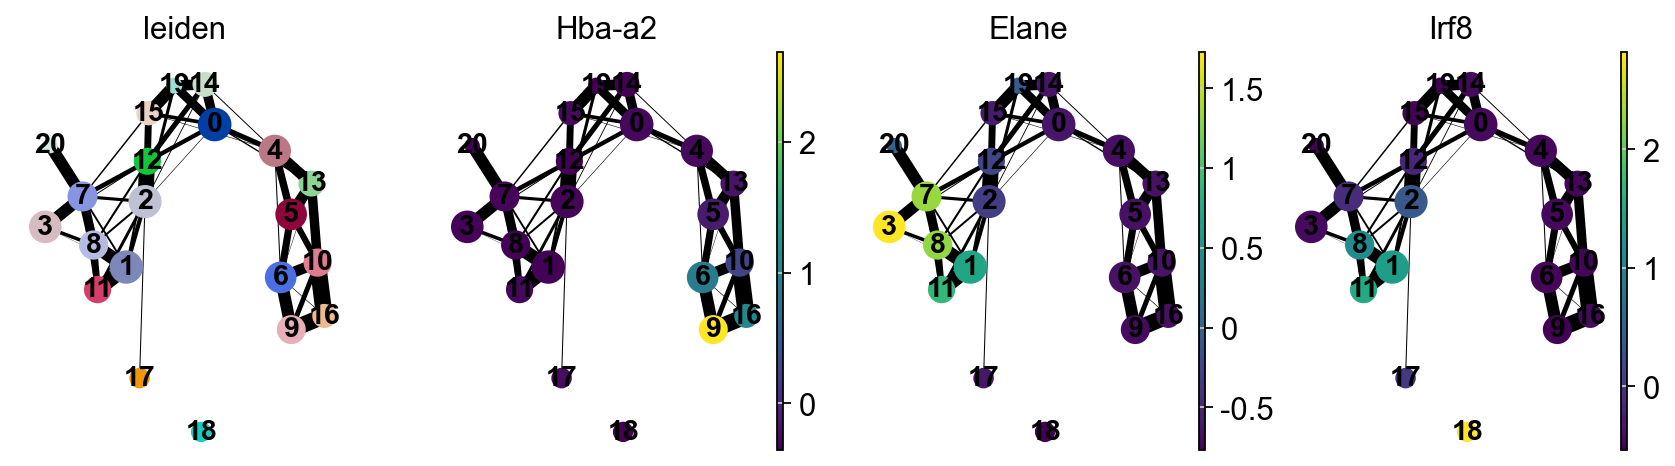

In [6]:
sc.tl.leiden(adata, resolution=1.0)

sc.tl.paga(adata, groups="leiden")

sc.pl.paga(adata, color=["leiden", "Hba-a2", "Elane", "Irf8"])



In [7]:
original_graph = adata.obsp["distances"].copy()

# paga_graph = adata.uns["paga"]["connectivities"].copy()


In [19]:
import ei_net

import importlib
importlib.reload(ei_net)

from ei_net import *

In [20]:
# compute the effective information of the original graph
ei_original = effective_information(original_graph)
print("Effective information of the original graph: {:.2f}".format(ei_original))
# compute the effectiveness of the original graph
ef_original = effectiveness(original_graph)
print("Effectiveness of the original graph: {:.2f}".format(ef_original))

# macro_mapping by adata.obs.leiden to dict
macro_mapping = adata.obs.leiden.to_dict()
# key and values are int
macro_mapping = {int(k): int(v) for k, v in macro_mapping.items()}
# Coarse-grain the network
G = check_network(original_graph)
M = create_macro(G, macro_mapping)
# Create a coarse-grained graph for visualization
G_macro = nx.DiGraph()
macro_nodes = np.unique(list(macro_mapping.values()))
for i in macro_nodes:
    for j in macro_nodes:
        if M[i, j] > 0:
            G_macro.add_edge(i, j, weight=M[i, j])

ei = effective_information(M)
eff = effectiveness(M)
print("Effective information of the coarse-grained graph: {:.2f}".format(ei))
print("Effectiveness of the coarse-grained graph: {:.2f}".format(eff))



Effective information of the original graph: 9.25
Effectiveness of the original graph: 0.81
Effective information of the coarse-grained graph: 3.95
Effectiveness of the coarse-grained graph: 0.90


In [21]:

# for resolution fro 0.1 to 5, compute the effective information of the PAGA graph
resolutions = np.linspace(0.1, 5, 20)
eis = []
effs = []

G = check_network(original_graph)
for resolution in resolutions:
    sc.tl.leiden(adata, resolution=resolution)

    # macro_mapping by adata.obs.leiden to dict
    macro_mapping = adata.obs.leiden.to_dict()
    # key and values are int
    macro_mapping = {int(k): int(v) for k, v in macro_mapping.items()}
    # Coarse-grain the network
    M = create_macro(G, macro_mapping)
    # Create a coarse-grained graph for visualization
    G_macro = nx.DiGraph()
    macro_nodes = np.unique(list(macro_mapping.values()))
    for i in macro_nodes:
        for j in macro_nodes:
            if M[i, j] > 0:
                G_macro.add_edge(i, j, weight=M[i, j])

    ei = effective_information(M)
    eff = effectiveness(M)

    eis.append(ei)
    effs.append(eff)

    

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 40 c

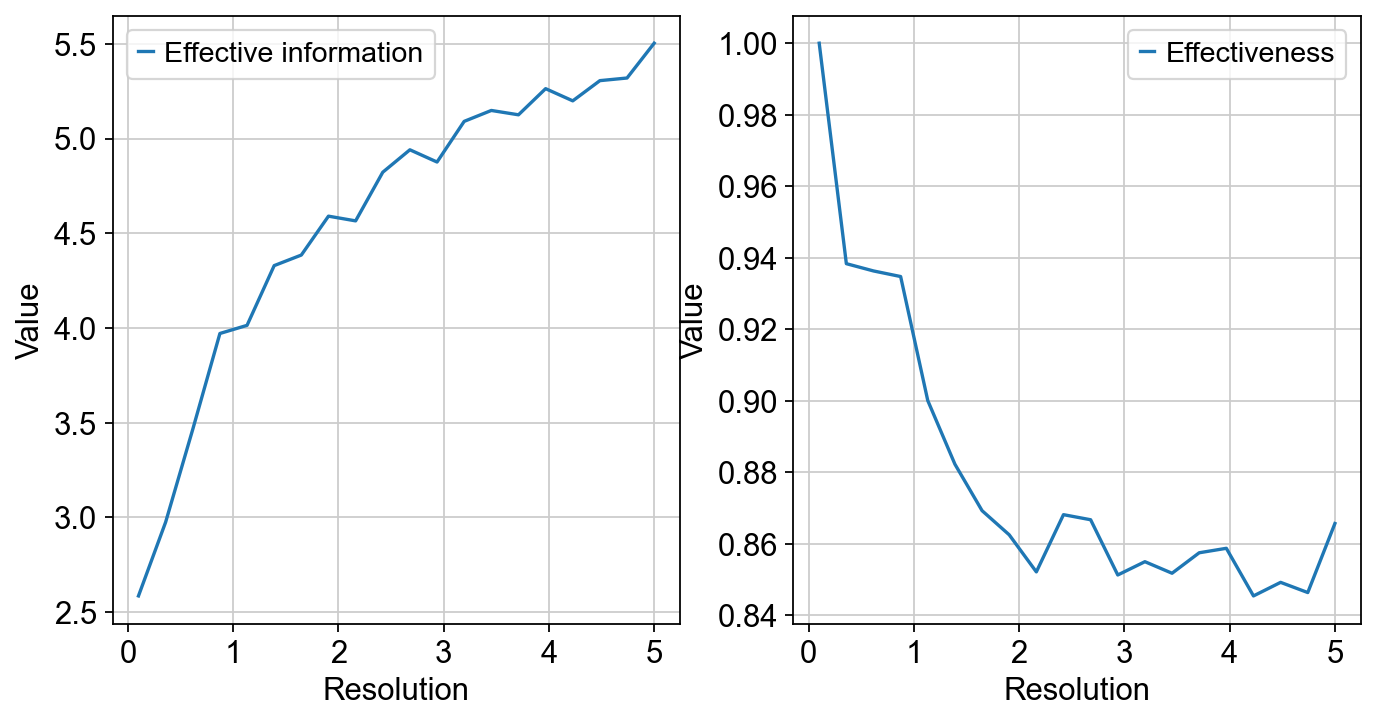

In [22]:
# plot effective information and effectiveness as a function of resolution
# set figure size
pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.plot(resolutions, eis, label="Effective information")
pl.xlabel("Resolution")
pl.ylabel("Value")
pl.legend()

pl.subplot(1, 2, 2)
pl.plot(resolutions, effs, label="Effectiveness")
pl.xlabel("Resolution")
pl.ylabel("Value")
pl.legend()
pl.show()


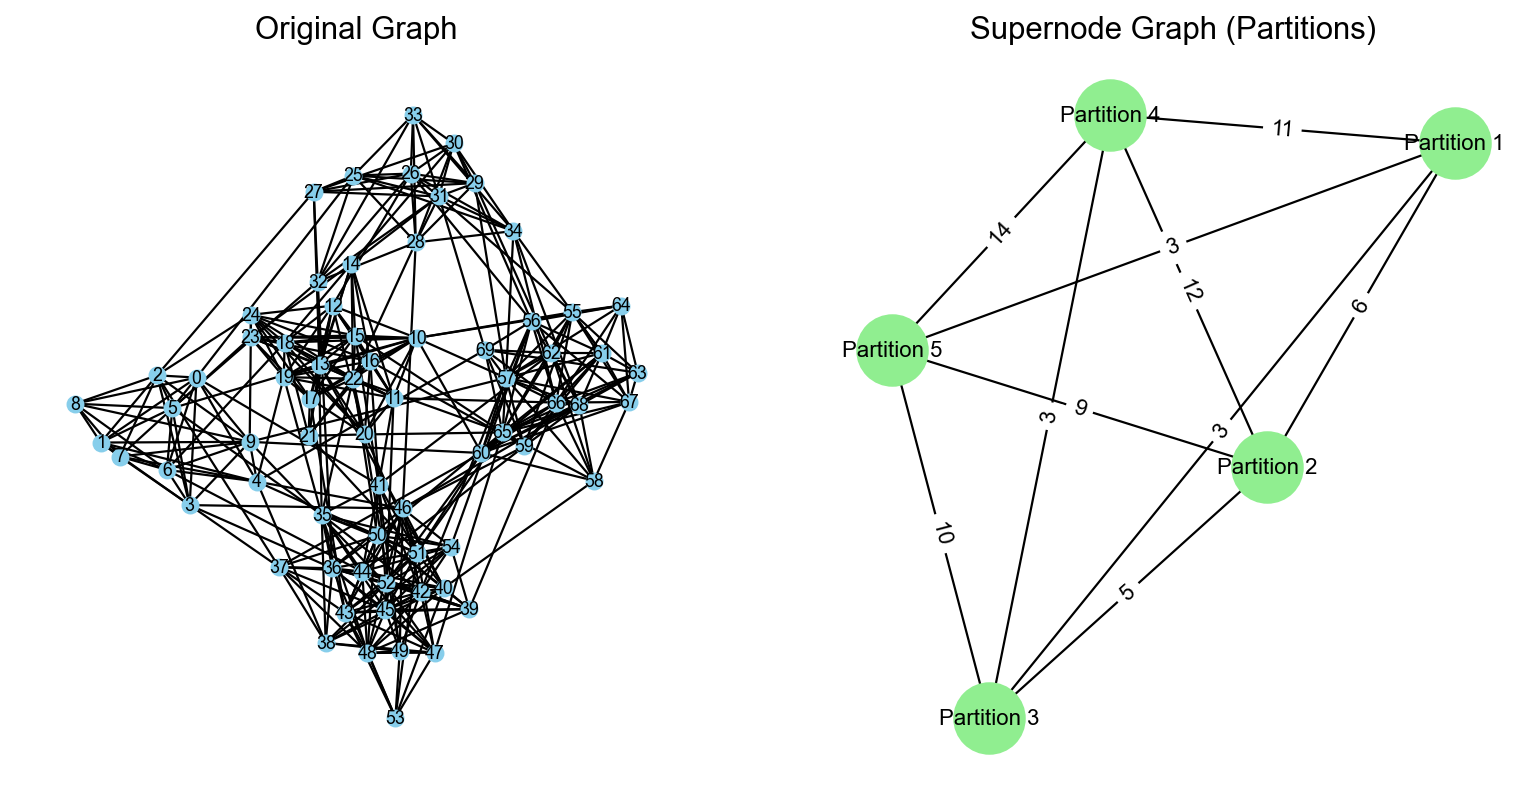

In [58]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.generators.community import stochastic_block_model

# Parameters for the SBM
sizes = [10, 15, 10, 20, 15]  # Sizes of each block
probs = [
    [0.8, 0.05, 0.02, 0.05, 0.02],
    [0.05, 0.7, 0.03, 0.04, 0.03],
    [0.02, 0.03, 0.8, 0.02, 0.04],
    [0.05, 0.04, 0.02, 0.6, 0.06],
    [0.02, 0.03, 0.04, 0.06, 0.7]
]  # Probabilities for edges within and between blocks

# Generate the graph using the stochastic block model
G = stochastic_block_model(sizes, probs, seed=42)

# Define the partitions
partitions = [
    list(range(0, 10)),
    list(range(10, 25)),
    list(range(25, 35)),
    list(range(35, 55)),
    list(range(55, 70))
]

def compute_cut_weight(G, partition1, partition2):
    cut_weight = 0
    for u in partition1:
        for v in partition2:
            if G.has_edge(u, v):
                cut_weight += G[u][v].get('weight', 1)
    return cut_weight

# Calculate the weight of the cut size between each pair of partitions
supernodes = nx.Graph()
for i in range(len(partitions)):
    supernodes.add_node(i, label=f"Partition {i+1}")

for i in range(len(partitions)):
    for j in range(i + 1, len(partitions)):
        cut_weight = compute_cut_weight(G, partitions[i], partitions[j])
        if cut_weight > 0:
            supernodes.add_edge(i, j, weight=cut_weight)

# Plot the original graph
plt.figure(figsize=(12, 6))

plt.subplot(121)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50, edge_color='k', font_size=8)
plt.title("Original Graph")

# Plot the supernode graph
plt.subplot(122)
supernode_pos = nx.spring_layout(supernodes, seed=42)
nx.draw(supernodes, supernode_pos, with_labels=True, labels=nx.get_node_attributes(supernodes, 'label'), node_color='lightgreen', node_size=1000, edge_color='k', font_size=10)
supernode_labels = nx.get_edge_attributes(supernodes, 'weight')
nx.draw_networkx_edge_labels(supernodes, supernode_pos, edge_labels=supernode_labels)
plt.title("Supernode Graph (Partitions)")

plt.show()


In [59]:
import ce_net

import importlib    
importlib.reload(ce_net)

from ce_net import *

# Calculate the causal emergence of the original graph
CE = causal_emergence_louvain(G)



In [60]:
print('resolution:', CE['resolution'])
print('EI_micro:', CE['EI_micro'])
print('EI_macro:', CE['EI_macro'])


# print the size of micro graph
micro_graph = CE['G_micro']
print('Size of micro graph:', len(micro_graph.nodes()))

# print number of clusters: distinct values in the CE['mapping']
print('Number of clusters:', len(set(CE['mapping'].values())))



resolution: 0.3002254208
EI_micro: 2.612426345836166
EI_macro: 2.612426345836166
Size of micro graph: 70
Number of clusters: 70


Text(0.5, 1.0, 'Macro Graph')

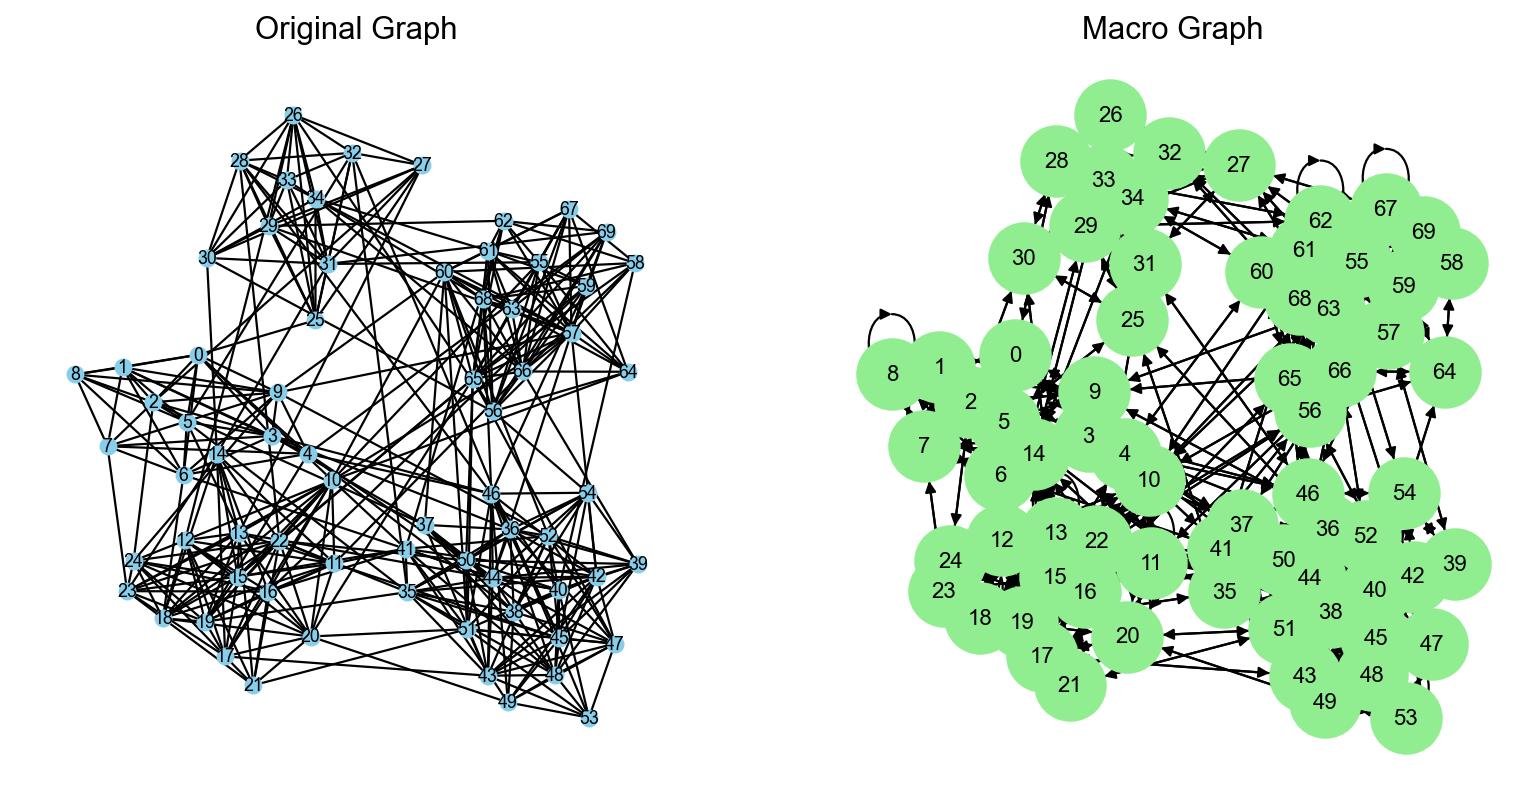

In [56]:
# plot  the original graph
plt.figure(figsize=(12, 6))

plt.subplot(121)
micro_graph = CE['G_micro']

pos = nx.spring_layout(micro_graph, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50, edge_color='k', font_size=8)
plt.title("Original Graph")

# plot the macro graph
plt.subplot(122)
macro_graph = CE['G_macro']
macro_pos = nx.spring_layout(macro_graph, seed=42)
nx.draw(macro_graph, macro_pos, with_labels=True, node_color='lightgreen', node_size=1000, edge_color='k', font_size=10)
plt.title("Macro Graph")


In [57]:
CE_spectral = causal_emergence_spectral(G)

print('EI_micro:', CE['EI_micro'])
print('EI_macro:', CE['EI_macro'])


# print the size of micro graph
micro_graph = CE['G_micro']
print('Size of micro graph:', len(micro_graph.nodes()))

# print number of clusters: distinct values in the CE['mapping']
print('Number of clusters:', len(set(CE['mapping'].values())))



EI_micro: 2.612426345836166
EI_macro: 2.612426345836166
Size of micro graph: 70
Number of clusters: 70


In [25]:
# effectiveness of the original graph
eff_original = effectiveness(G)

# effective information of the original graph
ei_original = effective_information(G)

# # determism of the original graph
# det_original = determinism(G)
# # degeneracy of the original graph
# deg_original = degeneracy(G)

# effectiveness of the supernode graph
eff_supernode = effectiveness(supernodes)

# effective information of the supernode graph
ei_supernode = effective_information(supernodes)
# # determism of the supernode graph
# det_supernode = determinism(supernodes)
# # degeneracy of the supernode graph
# deg_supernode = degeneracy(supernodes)

# print log2 number of nodes
print(f"Log2 number of nodes: {np.log2(G.number_of_nodes()):.2f}")
print(f"Effectiveness of the original graph: {eff_original:.2f}")
print(f"Effective information of the original graph: {ei_original:.2f}")
# print(f"Determinism of the original graph: {det_original:.2f}")
# print(f"Degeneracy of the original graph: {deg_original:.2f}")

# print log2 number of nodes
print(f"Log2 number of nodes: {np.log2(supernodes.number_of_nodes()):.2f}")
print(f"Effectiveness of the supernode graph: {eff_supernode:.2f}")
print(f"Effective information of the supernode graph: {ei_supernode:.2f}")
# print(f"Determinism of the supernode graph: {det_supernode:.2f}")
# print(f"Degeneracy of the supernode graph: {deg_supernode:.2f}")

Log2 number of nodes: 6.13
Effectiveness of the original graph: 0.43
Effective information of the original graph: 2.61
Log2 number of nodes: 2.32
Effectiveness of the supernode graph: 0.18
Effective information of the supernode graph: 0.42


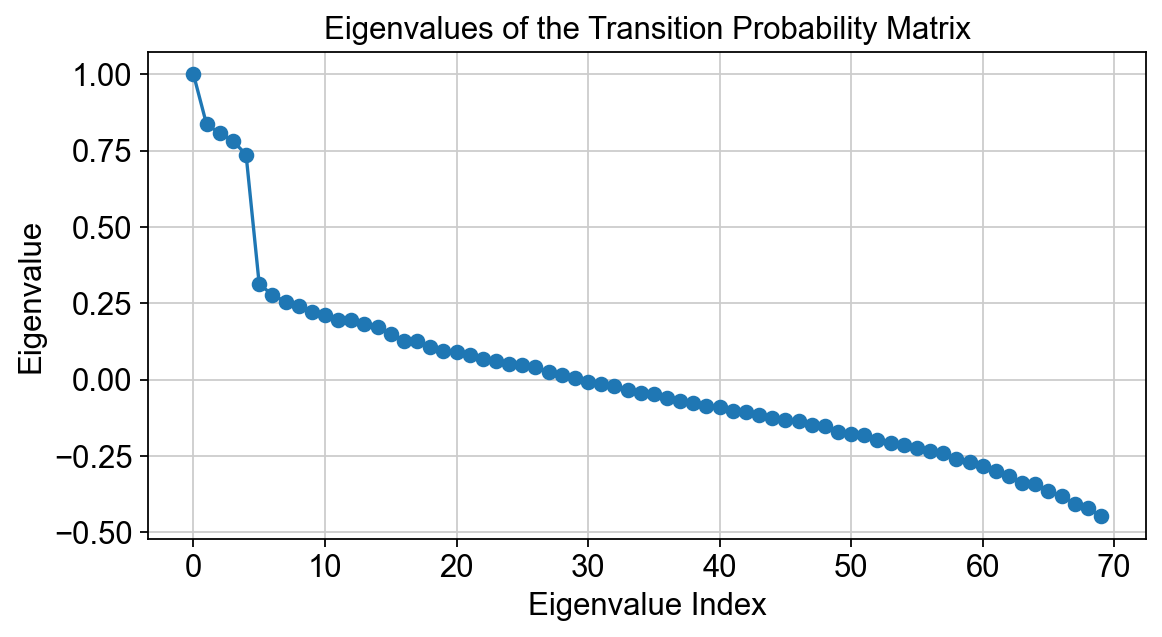

In [26]:
# Transition probability matrix of the original graph
P_original = nx.to_numpy_array(G, weight='weight')
P_original = P_original / P_original.sum(axis=1, keepdims=True)

# eigenvalues and eigenvectors of the transition probability matrix
eigenvalues, eigenvectors = np.linalg.eig(P_original.T)
stationary_distribution = eigenvectors[:, np.argmax(eigenvalues)].real
stationary_distribution /= stationary_distribution.sum()

# plot the eigenvaues
plt.figure(figsize=(8, 4))
plt.plot(np.sort(eigenvalues)[::-1], 'o-')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of the Transition Probability Matrix")
plt.grid(True)
plt.show()


Original Transition Matrix (W_out):
(70, 70)

Coarse-Grained Transition Matrix (M):
[[1.         0.         0.         0.         0.        ]
 [0.0326087  0.82608696 0.02717391 0.06521739 0.04891304]
 [0.03157895 0.05263158 0.77894737 0.03157895 0.10526316]
 [0.044      0.048      0.012      0.84       0.056     ]
 [0.01666667 0.05       0.05555556 0.07777778 0.8       ]]


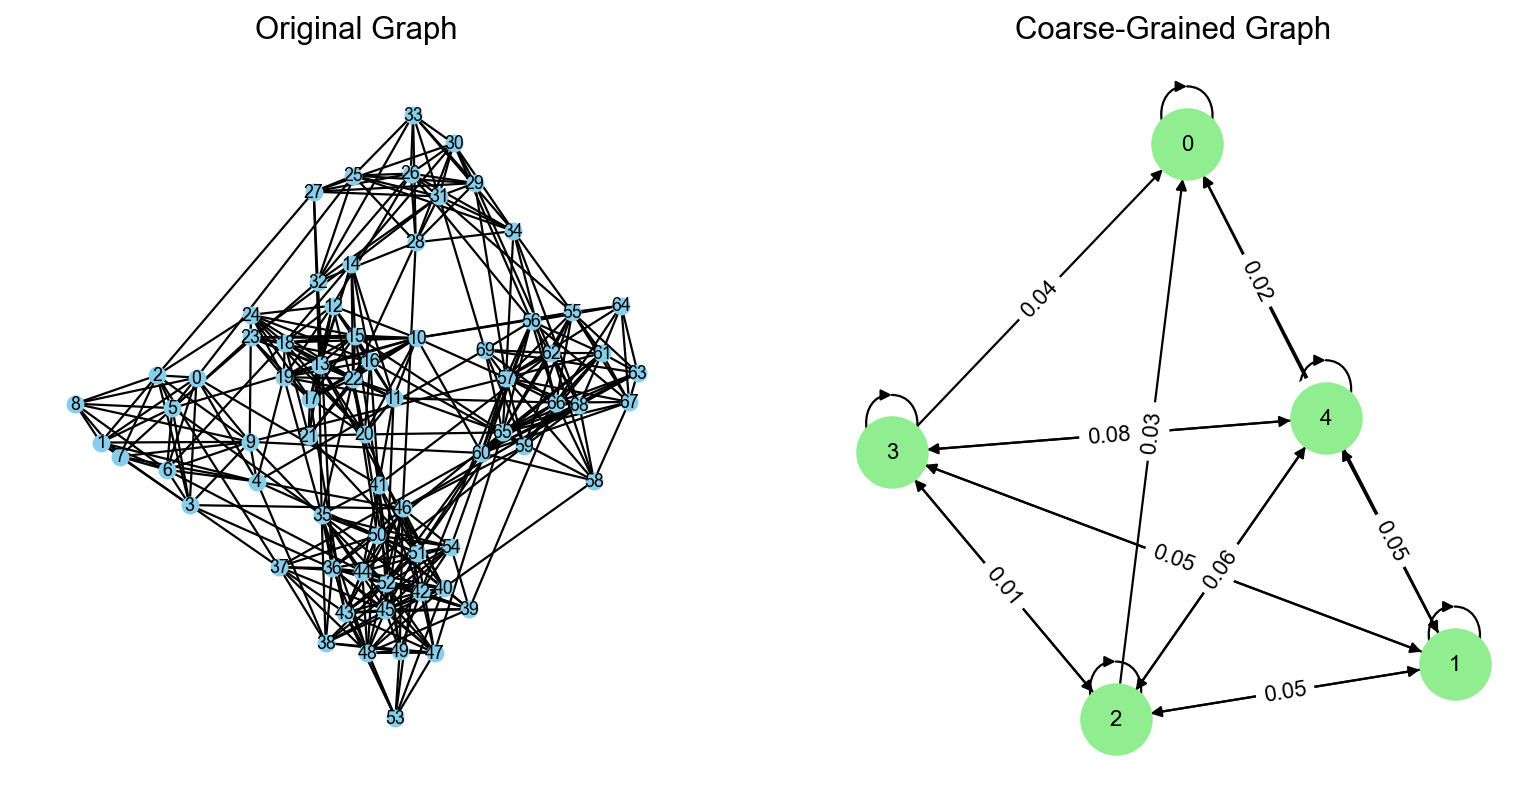

In [27]:


# Example usage

# Parameters for the SBM
sizes = [10, 15, 10, 20, 15]  # Sizes of each block
probs = [
    [0.8, 0.05, 0.02, 0.05, 0.02],
    [0.05, 0.7, 0.03, 0.04, 0.03],
    [0.02, 0.03, 0.8, 0.02, 0.04],
    [0.05, 0.04, 0.02, 0.6, 0.06],
    [0.02, 0.03, 0.04, 0.06, 0.7]
]  # Probabilities for edges within and between blocks

# Generate the graph using the stochastic block model
G = stochastic_block_model(sizes, probs, seed=42)

# Define the macro mapping (simplistic example of grouping nodes)
macro_mapping = {}
offset = 0
for i, size in enumerate(sizes):
    for j in range(size):
        macro_mapping[offset + j] = i
    offset += size

# Coarse-grain the network
M = create_macro(G, macro_mapping)

# Print the original and coarse-grained transition matrices
print("Original Transition Matrix (W_out):")
print(W_out(G).shape)
print("\nCoarse-Grained Transition Matrix (M):")
print(M)

# Plot the original graph
plt.figure(figsize=(12, 6))

plt.subplot(121)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50, edge_color='k', font_size=8)
plt.title("Original Graph")

# Create a coarse-grained graph for visualization
G_macro = nx.DiGraph()
macro_nodes = np.unique(list(macro_mapping.values()))
for i in macro_nodes:
    for j in macro_nodes:
        if M[i, j] > 0:
            G_macro.add_edge(i, j, weight=M[i, j])

# Plot the coarse-grained graph
plt.subplot(122)
macro_pos = nx.spring_layout(G_macro, seed=42)
nx.draw(G_macro, macro_pos, with_labels=True, node_color='lightgreen', node_size=1000, edge_color='k', font_size=10)
macro_labels = nx.get_edge_attributes(G_macro, 'weight')
nx.draw_networkx_edge_labels(G_macro, macro_pos, edge_labels={k: f"{v:.2f}" for k, v in macro_labels.items()})
plt.title("Coarse-Grained Graph")

plt.show()


In [28]:
# effective information of the original graph
ei_original = effective_information(G)
# effectiveness of the original graph
eff_original = effectiveness(G)

# effective information of the coarse-grained graph
ei_coarse = effective_information(G_macro)
# effectiveness of the coarse-grained graph
eff_coarse = effectiveness(G_macro)

print(f"Effective information of the original graph: {ei_original:.2f}")
print(f"Effectiveness of the original graph: {eff_original:.2f}")

print(f"Effective information of the coarse-grained graph: {ei_coarse:.2f}")
print(f"Effectiveness of the coarse-grained graph: {eff_coarse:.2f}")


Effective information of the original graph: 2.61
Effectiveness of the original graph: 0.43
Effective information of the coarse-grained graph: 1.48
Effectiveness of the coarse-grained graph: 0.64


In [29]:

# Example usage

# Parameters for the SBM
sizes = [10, 15, 10, 20, 15]  # Sizes of each block
probs = [
    [0.8, 0.05, 0.02, 0.05, 0.02],
    [0.05, 0.7, 0.03, 0.04, 0.03],
    [0.02, 0.03, 0.8, 0.02, 0.04],
    [0.05, 0.04, 0.02, 0.6, 0.06],
    [0.02, 0.03, 0.04, 0.06, 0.7]
]  # Probabilities for edges within and between blocks
# Generate the graph using the stochastic block model
G = stochastic_block_model(sizes, probs, seed=42)

# for resolution fro 0.1 to 5, compute the effective information of the PAGA graph
resolutions = np.linspace(0.1, 10, 100)
eis = []
effs = []

for resolution in resolutions:

    # louvain clustering
    partitions = nx.community.louvain_communities(G, resolution=resolution, seed=123)
    print(len(partitions))

    # Define the macro mapping by grouping nodes based on the partitions
    macro_mapping = {}
    for i, partition in enumerate(partitions):
        for node in partition:
            macro_mapping[node] = i

    # Coarse-grain the network
    M = create_macro(G, macro_mapping)

    # Create a coarse-grained graph for visualization
    G_macro = nx.DiGraph()
    macro_nodes = np.unique(list(macro_mapping.values()))
    for i in macro_nodes:
        for j in macro_nodes:
            if M[i, j] > 0:
                G_macro.add_edge(i, j, weight=M[i, j])

    # effective information of the coarse-grained graph
    ei_coarse = effective_information(G_macro)
    eis.append(ei_coarse)

    # effectiveness of the coarse-grained graph
    eff_coarse = effectiveness(G_macro)
    effs.append(eff_coarse)



1
1
3
4
5
5
5
5
5
5
5
5
5


/Users/yangyang/Library/CloudStorage/OneDrive-TheUniversityofQueensland/project/EI_clusters/code/einet/code/ei_net.py:220: RuntimeWarning: invalid value encountered in scalar divide
  """


5
5
5
5
5
5
5
5
6
6
6
6
7
7
8
8
8
10
11
12
12
12
14
15
15
16
18
17
18
18
18
20
22
22
23
22
23
23
28
30
29
30
31
33
34
34
34
35
36
37
38
38
38
43
44
45
45
45
45
45
46
48
48
48
47
48
48
48
50
50
53
54
55
55
55
56
58
58
58
59
59
60
60
60
60
60
61


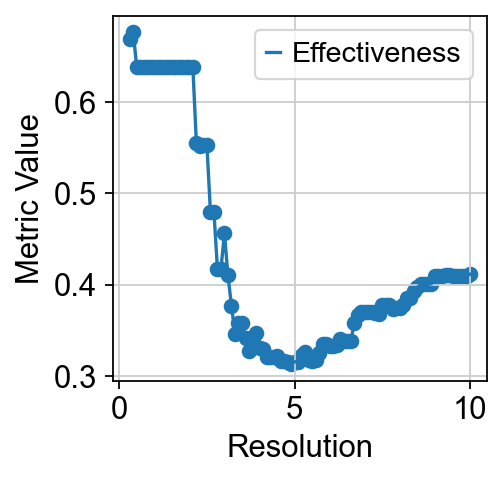

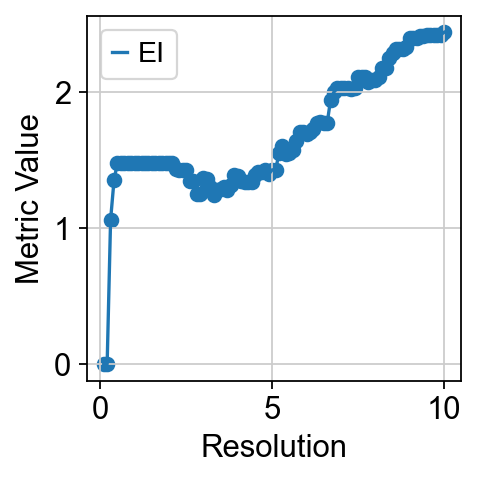

In [30]:
# plot effective information and effectiveness
plt.figure()
plt.plot(resolutions, effs, label="Effectiveness")
plt.scatter(resolutions, effs)
plt.xlabel("Resolution")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

plt.figure()
plt.plot(resolutions, eis, label="EI")
plt.scatter(resolutions, eis)
plt.xlabel("Resolution")
plt.ylabel("Metric Value")
plt.legend()
plt.show()



Original Transition Matrix (W_out):
(130, 130)

Coarse-Grained Transition Matrix (M):
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.02912621 0.7184466  0.02912621 0.06796117 0.03398058 0.01456311
  0.04368932 0.02427184 0.02427184 0.01456311]
 [0.02803738 0.05607477 0.63551402 0.01869159 0.06542056 0.03738318
  0.04672897 0.02803738 0.06542056 0.01869159]
 [0.03384615 0.04307692 0.00615385 0.72       0.05538462 0.01538462
  0.02461538 0.03384615 0.05230769 0.01538462]
 [0.01401869 0.03271028 0.03271028 0.08411215 0.72897196 0.01869159
  0.01401869 0.         0.05140187 0.02336449]
 [0.04       0.03       0.04       0.05       0.04       0.6
  0.07       0.         0.08       0.05      ]
 [0.         0.06521739 0.03623188 0.05797101 0.02173913 0.05072464
  0.71014493 0.00724638 0.05072464 0.        ]
 [0.01298701 0.06493506 0.03896104 0.14285714 0.         0.
  0.01298701 0.54545455 0.12987013 0.05194805]
 [0.02713178 0.01

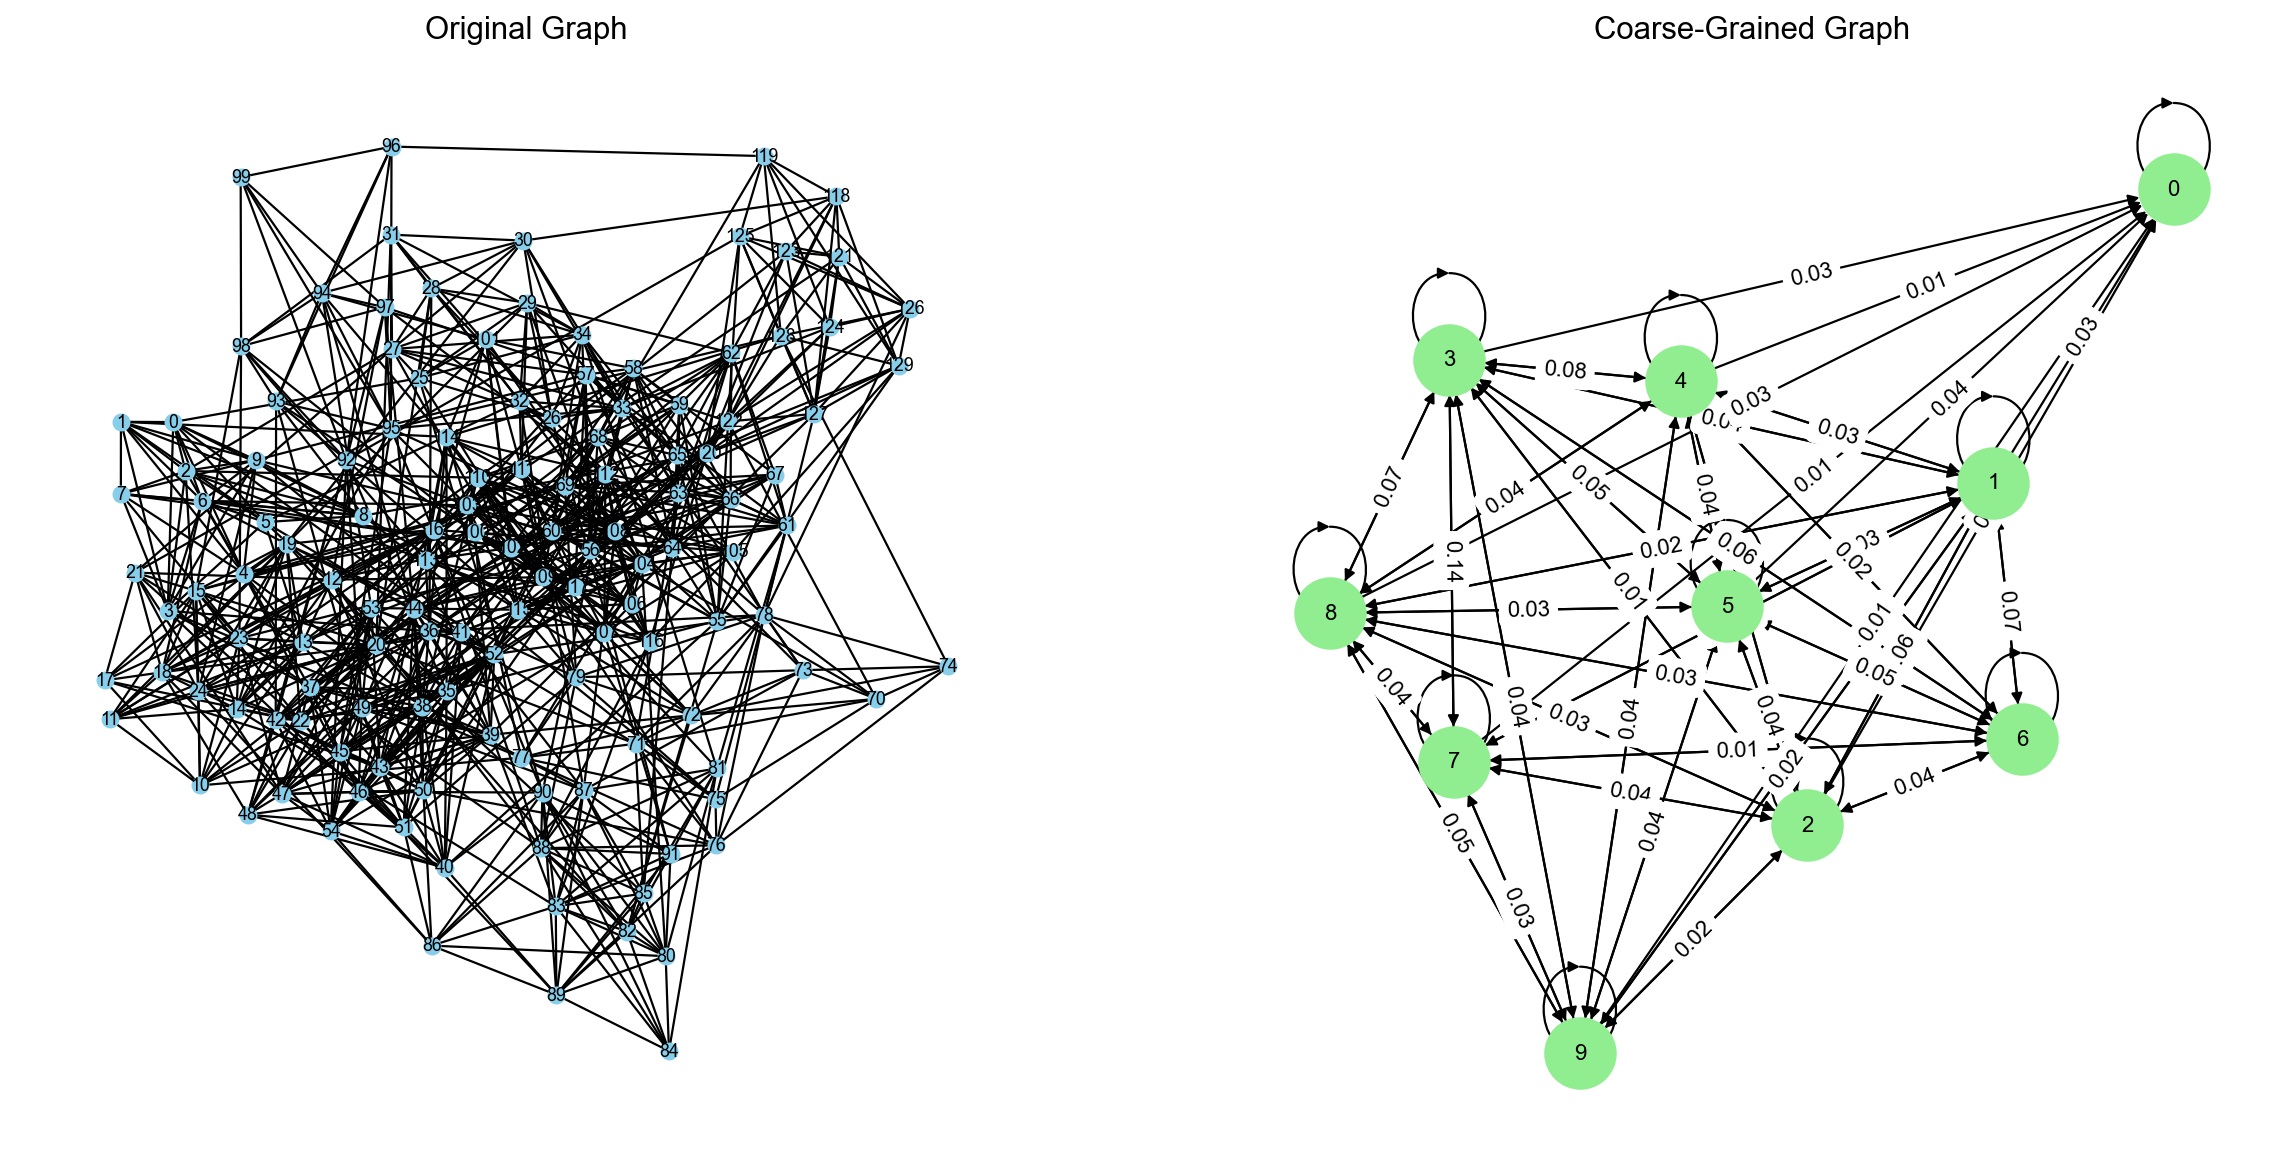

In [31]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.generators.community import stochastic_block_model

# def W_out(G):
#     """ Function to calculate the transition matrix of the graph G """
#     A = nx.adjacency_matrix(G).toarray()
#     P = A / A.sum(axis=1, keepdims=True)
#     return P

# def create_macro(G, macro_mapping):
#     """ Function to create a coarse-grained transition matrix """
#     P = W_out(G)
#     n_macro = max(macro_mapping.values()) + 1
#     M = np.zeros((n_macro, n_macro))
    
#     for i in range(len(G)):
#         for j in range(len(G)):
#             M[macro_mapping[i], macro_mapping[j]] += P[i, j]
    
#     for k in range(n_macro):
#         row_sum = M[k, :].sum()
#         if row_sum > 0:
#             M[k, :] /= row_sum
    
#     return M

# Parameters for the SBM
sizes = [10, 15, 10, 20, 15, 10, 12, 8, 18, 12]  # Sizes of each block
probs = [
    [0.8, 0.05, 0.02, 0.05, 0.02, 0.03, 0.01, 0.02, 0.04, 0.03],
    [0.05, 0.7, 0.03, 0.04, 0.03, 0.02, 0.05, 0.03, 0.02, 0.01],
    [0.02, 0.03, 0.8, 0.02, 0.04, 0.03, 0.01, 0.02, 0.03, 0.01],
    [0.05, 0.04, 0.02, 0.6, 0.06, 0.02, 0.03, 0.04, 0.05, 0.03],
    [0.02, 0.03, 0.04, 0.06, 0.7, 0.03, 0.01, 0.02, 0.04, 0.02],
    [0.03, 0.02, 0.03, 0.02, 0.03, 0.65, 0.04, 0.01, 0.02, 0.03],
    [0.01, 0.05, 0.01, 0.03, 0.01, 0.04, 0.75, 0.02, 0.03, 0.02],
    [0.02, 0.03, 0.02, 0.04, 0.02, 0.01, 0.02, 0.68, 0.04, 0.03],
    [0.04, 0.02, 0.03, 0.05, 0.04, 0.02, 0.03, 0.04, 0.6, 0.03],
    [0.03, 0.01, 0.01, 0.03, 0.02, 0.03, 0.02, 0.03, 0.03, 0.7]
]  # Probabilities for edges within and between blocks

# Generate the graph using the stochastic block model
G = stochastic_block_model(sizes, probs, seed=42)

# Define the macro mapping (simplistic example of grouping nodes)
macro_mapping = {}
offset = 0
for i, size in enumerate(sizes):
    for j in range(size):
        macro_mapping[offset + j] = i
    offset += size

# Coarse-grain the network
M = create_macro(G, macro_mapping)

# Print the original and coarse-grained transition matrices
print("Original Transition Matrix (W_out):")
print(W_out(G).shape)
print("\nCoarse-Grained Transition Matrix (M):")
print(M)

# Plot the original graph
plt.figure(figsize=(18, 9))

plt.subplot(121)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=50, edge_color='k', font_size=8)
plt.title("Original Graph")

# Create a coarse-grained graph for visualization
G_macro = nx.DiGraph()
macro_nodes = np.unique(list(macro_mapping.values()))
for i in macro_nodes:
    for j in macro_nodes:
        if M[i, j] > 0:
            G_macro.add_edge(i, j, weight=M[i, j])

# Plot the coarse-grained graph
plt.subplot(122)
macro_pos = nx.spring_layout(G_macro, seed=42)
nx.draw(G_macro, macro_pos, with_labels=True, node_color='lightgreen', node_size=1000, edge_color='k', font_size=10)
macro_labels = nx.get_edge_attributes(G_macro, 'weight')
nx.draw_networkx_edge_labels(G_macro, macro_pos, edge_labels={k: f"{v:.2f}" for k, v in macro_labels.items()})
plt.title("Coarse-Grained Graph")

plt.show()





In [32]:
# effective information of the original graph
ei_original = effective_information(G)
# effectiveness of the original graph
eff_original = effectiveness(G)

# effective information of the coarse-grained graph
ei_coarse = effective_information(G_macro)
# effectiveness of the coarse-grained graph
eff_coarse = effectiveness(G_macro)

print(f"Effective information of the original graph: {ei_original:.2f}")
print(f"Effectiveness of the original graph: {eff_original:.2f}")

print(f"Effective information of the coarse-grained graph: {ei_coarse:.2f}")
print(f"Effectiveness of the coarse-grained graph: {eff_coarse:.2f}")


Effective information of the original graph: 3.37
Effectiveness of the original graph: 0.48
Effective information of the coarse-grained graph: 1.68
Effectiveness of the coarse-grained graph: 0.50


In [33]:

# Example usage

# Parameters for the SBM
sizes = [10, 15, 10, 20, 15, 10, 12, 8, 18, 12]  # Sizes of each block
probs = [
    [0.8, 0.05, 0.02, 0.05, 0.02, 0.03, 0.01, 0.02, 0.04, 0.03],
    [0.05, 0.7, 0.03, 0.04, 0.03, 0.02, 0.05, 0.03, 0.02, 0.01],
    [0.02, 0.03, 0.8, 0.02, 0.04, 0.03, 0.01, 0.02, 0.03, 0.01],
    [0.05, 0.04, 0.02, 0.6, 0.06, 0.02, 0.03, 0.04, 0.05, 0.03],
    [0.02, 0.03, 0.04, 0.06, 0.7, 0.03, 0.01, 0.02, 0.04, 0.02],
    [0.03, 0.02, 0.03, 0.02, 0.03, 0.65, 0.04, 0.01, 0.02, 0.03],
    [0.01, 0.05, 0.01, 0.03, 0.01, 0.04, 0.75, 0.02, 0.03, 0.02],
    [0.02, 0.03, 0.02, 0.04, 0.02, 0.01, 0.02, 0.68, 0.04, 0.03],
    [0.04, 0.02, 0.03, 0.05, 0.04, 0.02, 0.03, 0.04, 0.6, 0.03],
    [0.03, 0.01, 0.01, 0.03, 0.02, 0.03, 0.02, 0.03, 0.03, 0.7]
]  # Probabilities for edges within and between blocks

# Generate the graph using the stochastic block model
G = stochastic_block_model(sizes, probs, seed=42)

# for resolution fro 0.1 to 5, compute the effective information of the PAGA graph
resolutions = np.linspace(0.1, 10, 100)
eis = []
effs = []

for resolution in resolutions:

    # louvain clustering
    partitions = nx.community.louvain_communities(G, resolution=resolution, seed=123)
    print(len(partitions))

    # Define the macro mapping by grouping nodes based on the partitions
    macro_mapping = {}
    for i, partition in enumerate(partitions):
        for node in partition:
            macro_mapping[node] = i

    # Coarse-grain the network
    M = create_macro(G, macro_mapping)

    # Create a coarse-grained graph for visualization
    G_macro = nx.DiGraph()
    macro_nodes = np.unique(list(macro_mapping.values()))
    for i in macro_nodes:
        for j in macro_nodes:
            if M[i, j] > 0:
                G_macro.add_edge(i, j, weight=M[i, j])

    # effective information of the coarse-grained graph
    ei_coarse = effective_information(G_macro)
    eis.append(ei_coarse)

    # effectiveness of the coarse-grained graph
    eff_coarse = effectiveness(G_macro)
    effs.append(eff_coarse)



1
1
2
4
5
8
8
8
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
13
13
13
14
14
14
14
15
16
16
16
17
17
17
17
18
18
20
20
20
19
23
23
22
26
27
27
31
31
33
35
35
35
37
40
40
39
40
41
42
43
44
45
45
46
46
46
46
50
51
52
52
51
52
54
55
59
62
62
62
63
61
62
64
65
67


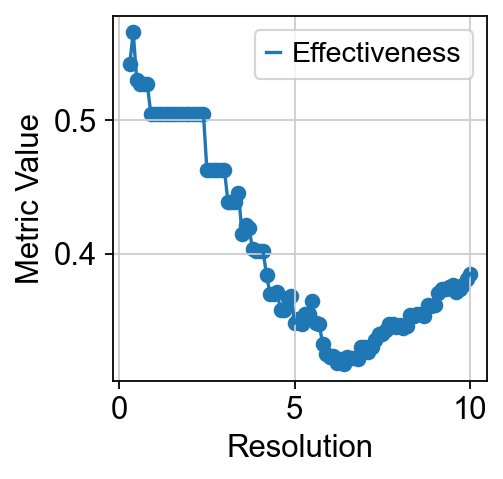

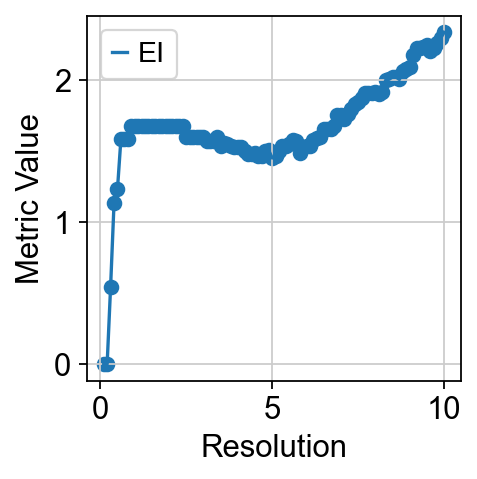

In [34]:
# plot effective information and effectiveness
plt.figure()
plt.plot(resolutions, effs, label="Effectiveness")
plt.scatter(resolutions, effs)
plt.xlabel("Resolution")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

plt.figure()
plt.plot(resolutions, eis, label="EI")
plt.scatter(resolutions, eis)
plt.xlabel("Resolution")
plt.ylabel("Metric Value")
plt.legend()
plt.show()



In [ ]:
# Varying Stochastic block model to vaildate the effectiveness and effective information 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.generators.community import stochastic_block_model

# Parameters for the SBM
